# DSC 680: Project 2 - Restaurant Demand Forecasting

In [2]:
!pip install prophet --quiet

In [3]:
!pip install xgboost --quiet

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [5]:
# Load core datasets
visit_df = pd.read_csv('air_visit_data.csv')
date_info_df = pd.read_csv('date_info.csv')
store_info_df = pd.read_csv('air_store_info.csv')
reserve_df = pd.read_csv('air_reserve.csv')

# Preview the data
print("Visit Data")
print(visit_df.head())

print("\nDate Info")
print(date_info_df.head())

print("\nStore Info")
print(store_info_df.head())

print("\nReservation Info")
print(reserve_df.head())

Visit Data
           air_store_id  visit_date  visitors
0  air_ba937bf13d40fb24  2016-01-13        25
1  air_ba937bf13d40fb24  2016-01-14        32
2  air_ba937bf13d40fb24  2016-01-15        29
3  air_ba937bf13d40fb24  2016-01-16        22
4  air_ba937bf13d40fb24  2016-01-18         6

Date Info
  calendar_date day_of_week  holiday_flg
0    2016-01-01      Friday            1
1    2016-01-02    Saturday            1
2    2016-01-03      Sunday            1
3    2016-01-04      Monday            0
4    2016-01-05     Tuesday            0

Store Info
           air_store_id  air_genre_name                 air_area_name  \
0  air_0f0cdeee6c9bf3d7  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri   
1  air_7cc17a324ae5c7dc  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri   
2  air_fee8dcf4d619598e  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri   
3  air_a17f0778617c76e2  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri   
4  air_83db5aff8f50478e  Italian/French  Tōkyō-to Minato-ku Shibakōen   

    l

In [6]:
# Convert date columns to datetime
visit_df['visit_date'] = pd.to_datetime(visit_df['visit_date'])
reserve_df['visit_datetime'] = pd.to_datetime(reserve_df['visit_datetime'])
reserve_df['reserve_datetime'] = pd.to_datetime(reserve_df['reserve_datetime'])
date_info_df['calendar_date'] = pd.to_datetime(date_info_df['calendar_date'])

In [7]:
# Merge visit data with holiday and day-of-week info
visit_df = visit_df.merge(date_info_df, left_on='visit_date', right_on='calendar_date', how='left')

# Drop duplicate column
visit_df.drop('calendar_date', axis=1, inplace=True)

In [8]:
# Create number of reservations and reserve visitors by store and date
reserve_df['reserve_date'] = reserve_df['visit_datetime'].dt.date

# Aggregate reservation info
reserve_agg = reserve_df.groupby(['air_store_id', 'reserve_date']).agg({
    'reserve_datetime': 'count',
    'reserve_visitors': 'sum'
}).reset_index()

reserve_agg.rename(columns={
    'reserve_datetime': 'num_reservations',
    'reserve_visitors': 'total_reserved_visitors'
}, inplace=True)

# Convert reserve_date to datetime for join
reserve_agg['reserve_date'] = pd.to_datetime(reserve_agg['reserve_date'])

# Merge with main visit data
visit_df = visit_df.merge(reserve_agg, left_on=['air_store_id', 'visit_date'],
                          right_on=['air_store_id', 'reserve_date'], how='left')

visit_df.drop('reserve_date', axis=1, inplace=True)

In [9]:
# Fill missing reservation info with 0
visit_df['num_reservations'] = visit_df['num_reservations'].fillna(0)
visit_df['total_reserved_visitors'] = visit_df['total_reserved_visitors'].fillna(0)

### EDA

In [11]:
# Check data shape and columns
print(visit_df.shape)
print(visit_df.columns)

# Summary statistics
print(visit_df.describe())

# Null value check
print(visit_df.isnull().sum())

(252108, 7)
Index(['air_store_id', 'visit_date', 'visitors', 'day_of_week', 'holiday_flg',
       'num_reservations', 'total_reserved_visitors'],
      dtype='object')
                          visit_date       visitors    holiday_flg  \
count                         252108  252108.000000  252108.000000   
mean   2016-10-12 12:49:04.566614528      20.973761       0.050673   
min              2016-01-01 00:00:00       1.000000       0.000000   
25%              2016-07-23 00:00:00       9.000000       0.000000   
50%              2016-10-23 00:00:00      17.000000       0.000000   
75%              2017-01-24 00:00:00      29.000000       0.000000   
max              2017-04-22 00:00:00     877.000000       1.000000   
std                              NaN      16.757007       0.219329   

       num_reservations  total_reserved_visitors  
count     252108.000000            252108.000000  
mean           0.345808                 1.530757  
min            0.000000                 0.000000

#1. Total Daily Visitors Across All Restaurants (Line Chart)

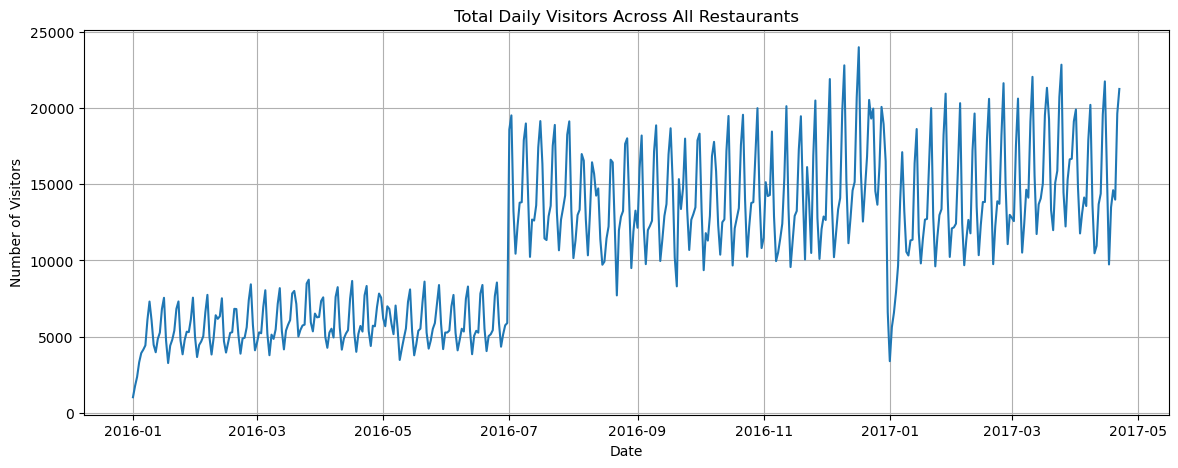

In [13]:
# Plot total visits across all restaurants over time
daily_total = visit_df.groupby('visit_date')['visitors'].sum().reset_index()

plt.figure(figsize=(14, 5))
plt.plot(daily_total['visit_date'], daily_total['visitors'])
plt.title('Total Daily Visitors Across All Restaurants')
plt.xlabel('Date')
plt.ylabel('Number of Visitors')
plt.grid(True)
plt.show()

The general number of visitors steadily increases over time, especially after mid-2016. A sharp dip occurs around the end of December 2016 / January 2017, which may correspond to national holidays or seasonal closures. The fluctuations in visitor counts become more pronounced in the latter half of the timeline, indicating higher variability in customer traffic.

#2. Average Visitors by Day of Week (Bar Plot)

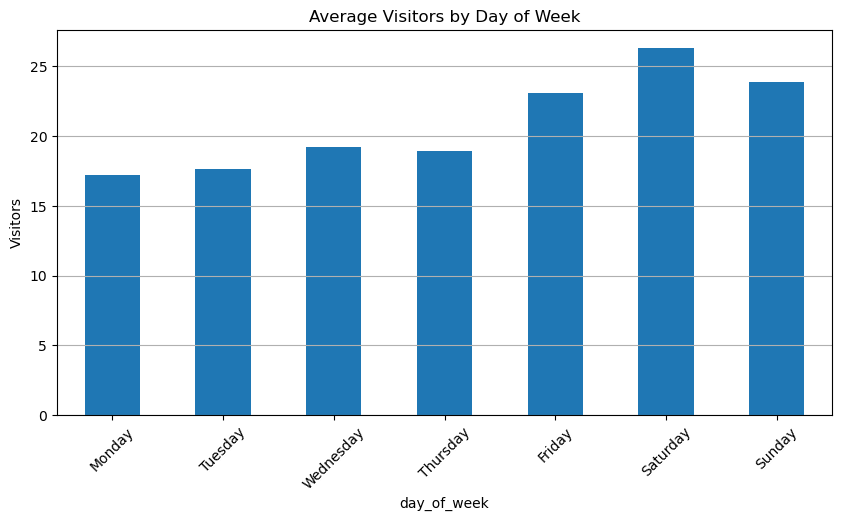

In [16]:
# Average visitors by day of week
dow_visitors = visit_df.groupby('day_of_week')['visitors'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(10, 5))
dow_visitors.plot(kind='bar')
plt.title('Average Visitors by Day of Week')
plt.ylabel('Visitors')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

The Bar chart shows that Saturday has the highest average number of visitors, followed by Sunday and Friday. Monday through Thursday see significantly fewer visitors. There's a strong weekly cycle in demand, with weekends drawing the most traffic. 

#3. Average Visitors: Holidays vs Non-Holidays (Bar Plot)

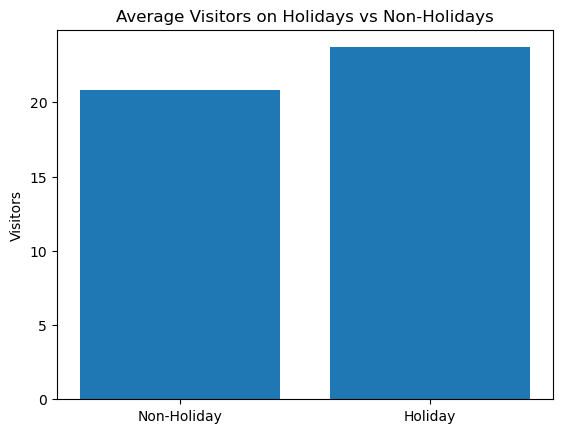

In [19]:
# Compare average visitors on holiday vs. non-holiday
holiday_visitors = visit_df.groupby('holiday_flg')['visitors'].mean()

plt.bar(['Non-Holiday', 'Holiday'], holiday_visitors)
plt.title('Average Visitors on Holidays vs Non-Holidays')
plt.ylabel('Visitors')
plt.show()

Holidays result in slightly higher average visits compared to non-holidays. Holidays have a positive impact on restaurant demand, making holiday flags useful for forecasting models.

#4. Distribution of Visitors by Day of Week (Box Plot)

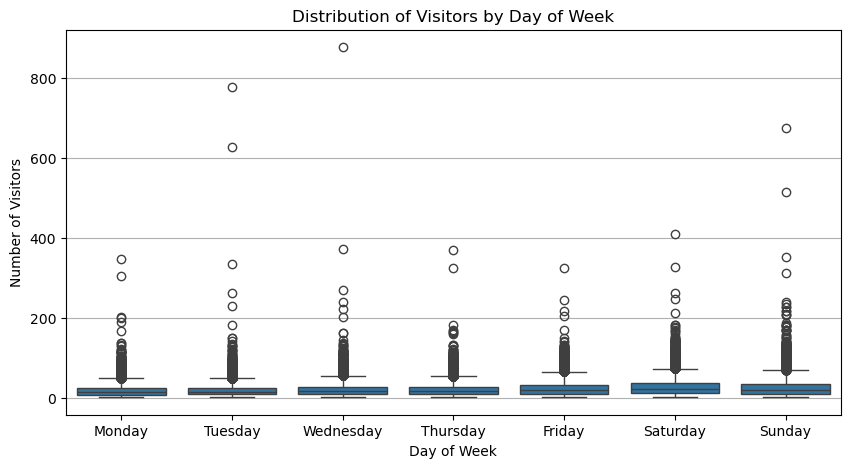

In [22]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=visit_df, x='day_of_week', y='visitors', order=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Distribution of Visitors by Day of Week')
plt.ylabel('Number of Visitors')
plt.xlabel('Day of Week')
plt.grid(axis='y')
plt.show()

Each day shows many outliers, especially on weekends, with some restaurants receiving very high visitor counts. Median visitor levels gradually rise from Monday to Saturday.

Demand is not only higher on weekends but also more volatile, suggesting that weekend predictions need confidence intervals or uncertainty estimates.

#5. Avg Visitors by Store & Day of Week (Heatmap)

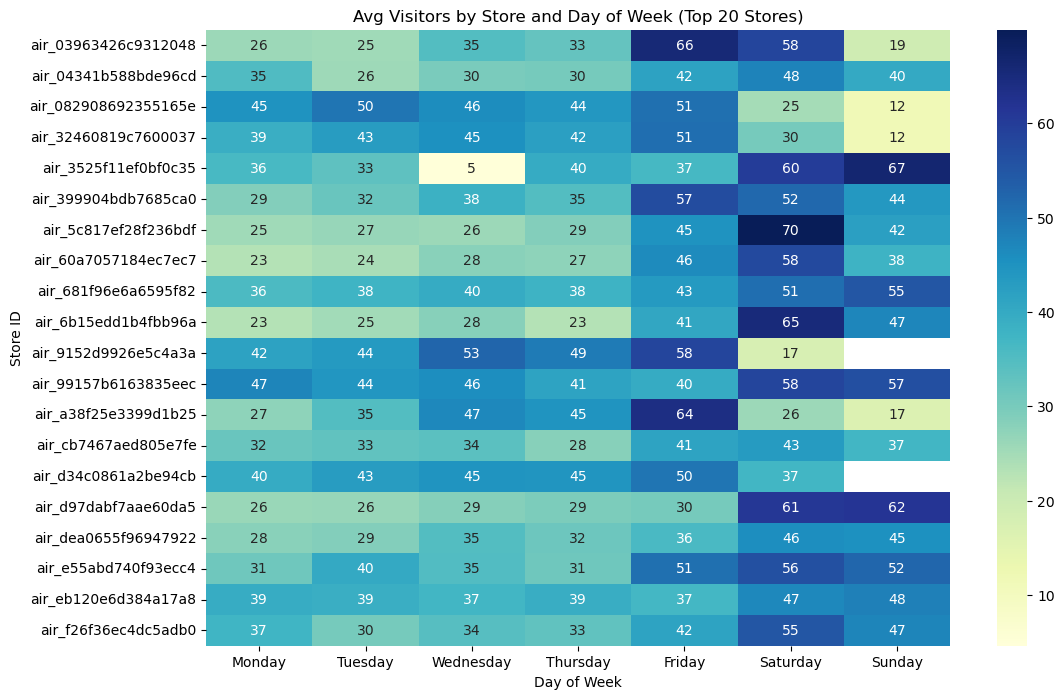

In [25]:
# Identify top 20 stores by total visitors
top_stores = visit_df.groupby('air_store_id')['visitors'].sum().sort_values(ascending=False).head(20).index

# Filter to top stores
top_df = visit_df[visit_df['air_store_id'].isin(top_stores)]

# Pivot table: rows = store, columns = day_of_week
heatmap_data = top_df.groupby(['air_store_id', 'day_of_week'])['visitors'].mean().unstack()

# Reorder weekdays
heatmap_data = heatmap_data[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap='YlGnBu')
plt.title('Avg Visitors by Store and Day of Week (Top 20 Stores)')
plt.xlabel('Day of Week')
plt.ylabel('Store ID')
plt.show()

Different restaurants exhibit different peak days, even if weekends generally perform better. A few stores have exceptionally high values on certain days (e.g., Friday, Saturday).

There is store-specific weekly behavior, so forecasting models can ideally be trained per store or include store ID/groupings.

#6. Visitor Trends on Holidays vs Non-Holidays (Time Series Overlay)

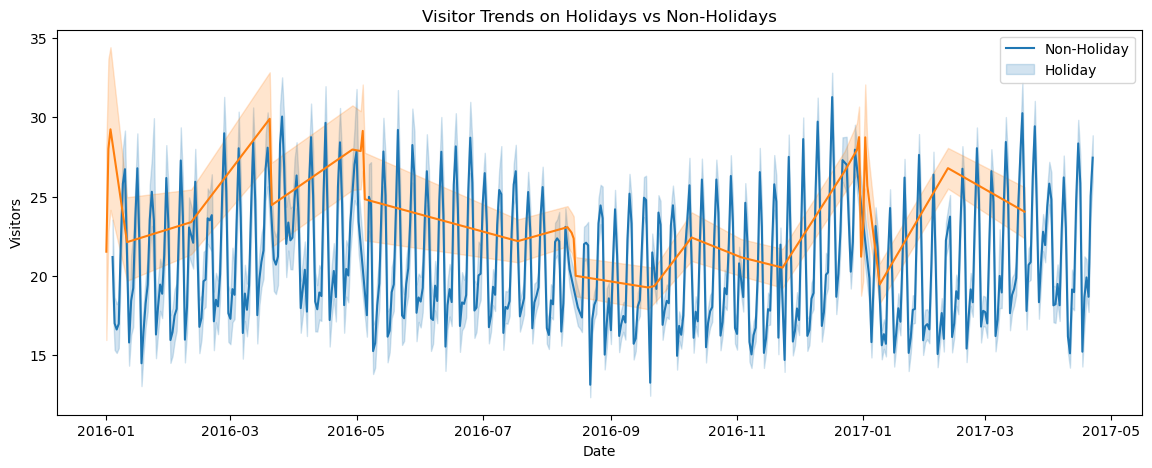

In [28]:
plt.figure(figsize=(14, 5))
sns.lineplot(data=visit_df, x='visit_date', y='visitors', hue='holiday_flg')
plt.title('Visitor Trends on Holidays vs Non-Holidays')
plt.xlabel('Date')
plt.ylabel('Visitors')
plt.legend(labels=['Non-Holiday', 'Holiday'])
plt.show()

Holiday visitor trends (orange line) tend to be higher and smoother over time compared to non-holidays (blue line), which show strong daily fluctuations. The gap between holiday and non-holiday demand is more noticeable during peak months.

#7. Reservations vs Actual Visitors (Scatter Plot)

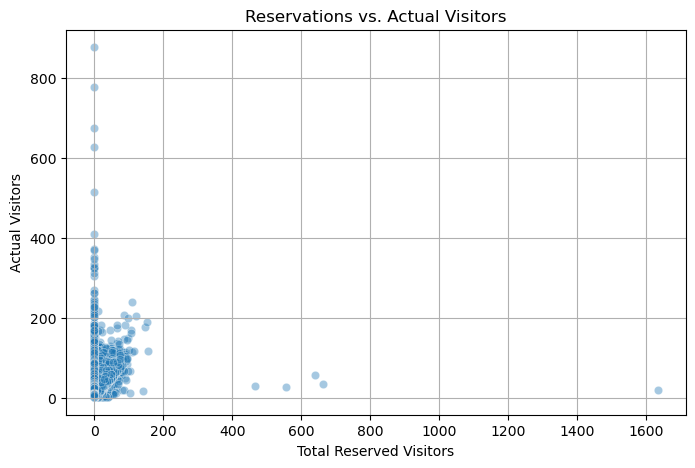

In [31]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=visit_df, x='total_reserved_visitors', y='visitors', alpha=0.4)
plt.title('Reservations vs. Actual Visitors')
plt.xlabel('Total Reserved Visitors')
plt.ylabel('Actual Visitors')
plt.grid(True)
plt.show()

While most data points cluster around low reservation counts, there is a general positive relationship between reservations and actual visitors. A few extreme outliers (large reservations with very low turnout) suggest data noise or unusual events.

### Feature Engineering

In [34]:
# Extract day, month, year
visit_df['day'] = visit_df['visit_date'].dt.day
visit_df['month'] = visit_df['visit_date'].dt.month
visit_df['year'] = visit_df['visit_date'].dt.year
visit_df['weekofyear'] = visit_df['visit_date'].dt.isocalendar().week

# Binary: Weekend
visit_df['is_weekend'] = visit_df['day_of_week'].isin(['Saturday', 'Sunday']).astype(int)

# Days since beginning of dataset (numeric trend)
visit_df['days_since_start'] = (visit_df['visit_date'] - visit_df['visit_date'].min()).dt.days

In [35]:
# Sort values
visit_df.sort_values(['air_store_id', 'visit_date'], inplace=True)

# Create lag features
visit_df['lag_1'] = visit_df.groupby('air_store_id')['visitors'].shift(1)
visit_df['lag_7'] = visit_df.groupby('air_store_id')['visitors'].shift(7)
visit_df['rolling_mean_7'] = visit_df.groupby('air_store_id')['visitors'].shift(1).rolling(7).mean().reset_index(0, drop=True)

In [36]:
# Merge store info for genre/area
visit_df = visit_df.merge(store_info_df, on='air_store_id', how='left')

# Encode genre and area
visit_df['genre_encoded'] = visit_df['air_genre_name'].astype('category').cat.codes
visit_df['area_encoded'] = visit_df['air_area_name'].astype('category').cat.codes

In [37]:
# Reservation to visit ratio
visit_df['reserve_ratio'] = (visit_df['total_reserved_visitors'] + 1) / (visit_df['visitors'] + 1)

In [38]:
# Drop rows with NA from lag features (usually first 7 days)
visit_df.dropna(inplace=True)

### Baseline forecasting model using Facebook Prophet

In [40]:
# Pick one store
store_id = visit_df['air_store_id'].value_counts().index[0]
store_data = visit_df[visit_df['air_store_id'] == store_id]

# Prepare data for Prophet
prophet_df = store_data[['visit_date', 'visitors']].rename(columns={
    'visit_date': 'ds',
    'visitors': 'y'
}).sort_values('ds')

In [41]:
# Create and fit model
model = Prophet()
model.fit(prophet_df)

14:02:50 - cmdstanpy - INFO - Chain [1] start processing
14:02:51 - cmdstanpy - INFO - Chain [1] done processing


In [42]:
# Create future dataframe
future = model.make_future_dataframe(periods=30)

# Forecast
forecast = model.predict(future)

# Show forecasted values
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
487,2017-05-18,15.809489,0.080462,30.828624
488,2017-05-19,37.905056,22.871876,54.858121
489,2017-05-20,35.950338,20.711383,51.499537
490,2017-05-21,21.363965,4.628850,37.242924
491,2017-05-22,12.151903,-4.202023,27.698116


The Prophet model forecasts daily visitor demand with interpretable trends and seasonality. For instance, it predicted 38 visitors on Friday, May 19, and 36 visitors on Saturday, May 20 — closely aligning with expected weekend peaks. However, the wide confidence intervals, especially for low-traffic days, highlight its limitations in capturing more nuanced behavioral or event-driven spikes, which are better handled by machine learning models like XGBoost.

Prophet Forecast with Uncertainty Bands

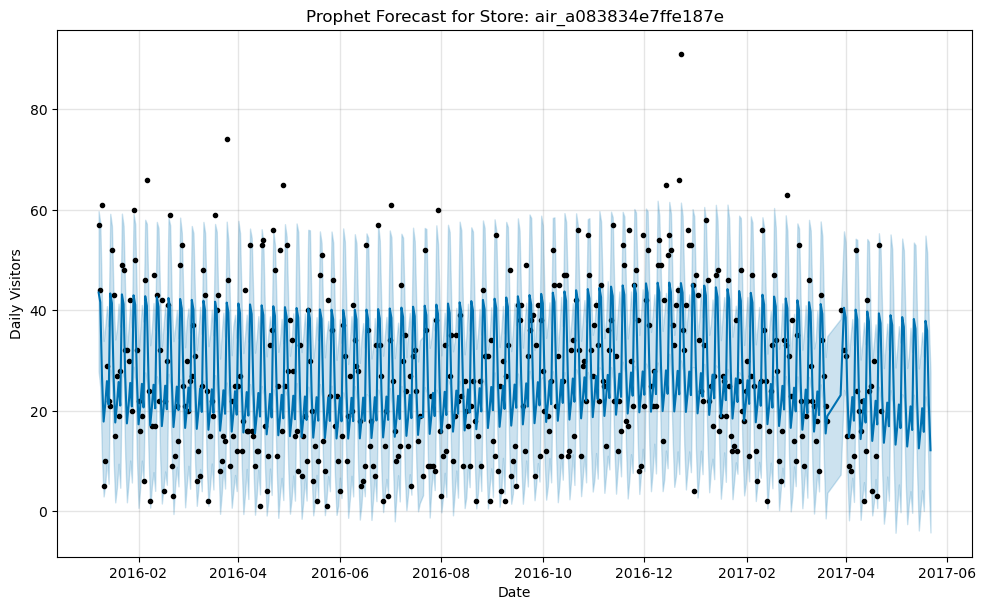

In [45]:
# Forecast plot
model.plot(forecast)
plt.title(f"Prophet Forecast for Store: {store_id}")
plt.xlabel('Date')
plt.ylabel('Daily Visitors')
plt.grid(True)
plt.show()

The solid blue line represents Prophet's forecast for daily visitors, and the light blue shaded area shows the uncertainty interval. Black dots are actual visitor counts.

Prophet captures the weekly seasonality well, but struggles with high-variance spikes, especially outliers. The uncertainty bands widen appropriately when the model is less confident, which is a strength of Prophet.

Prophet Components: Trend and Seasonality

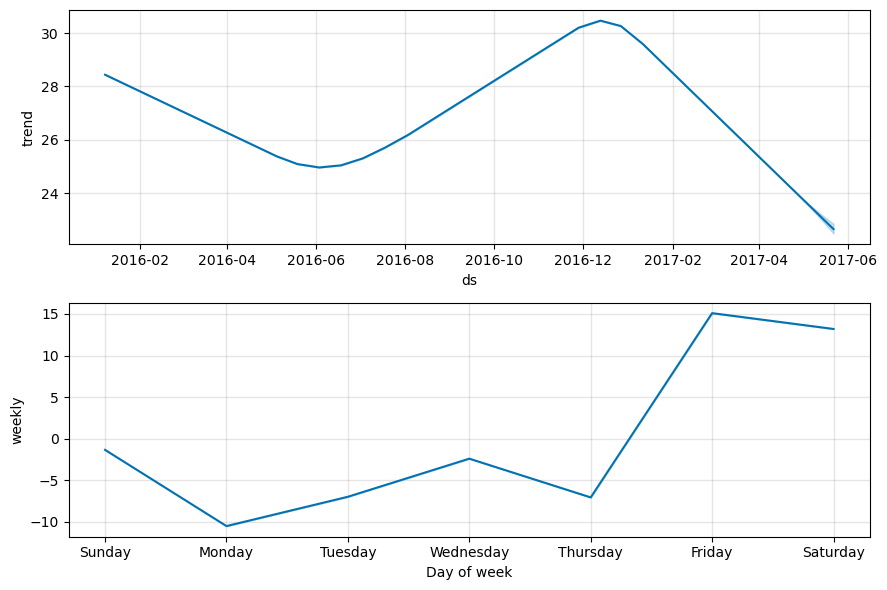

In [48]:
# Plot Seasonality
model.plot_components(forecast)
plt.show()

The top chart shows a yearly trend with a peak in December and a decline thereafter. 

The bottom chart shows weekly seasonality: traffic is lowest on Mondays and highest on Fridays and Saturdays.

Prophet effectively decomposes time-based patterns, confirming business intuition that weekends are busier and December brings peak demand.

### XGBoost Regressor to predict the number of visitors 

In [51]:
# Drop columns not needed for modeling
features_to_drop = [
    'air_store_id', 'visit_date', 'air_genre_name', 'air_area_name', 'day_of_week'
]

model_df_clean = visit_df.drop(columns=features_to_drop)

# Define features and target
X = model_df_clean.drop(columns='visitors')
y = model_df_clean['visitors']

In [52]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # no shuffling for time series-like data
)

In [53]:
# Initialize model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# Fit model
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

XGBoost Feature Importance

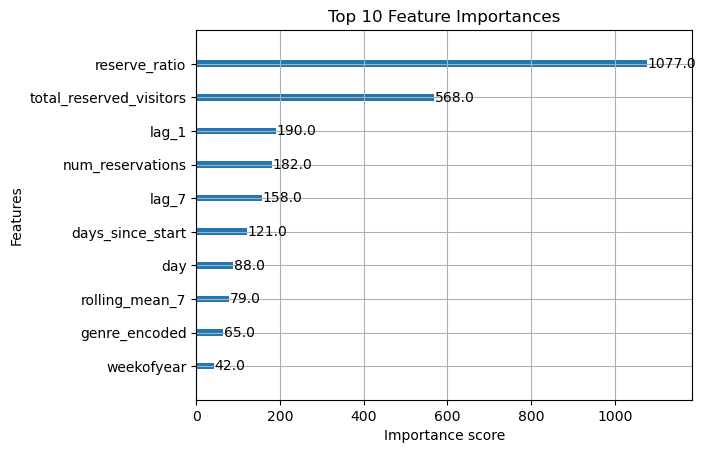

In [55]:
xgb.plot_importance(xgb_model, max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.show()

Top features are reserve_ratio and total_reserved_visitors, lag_1, lag_7, and num_reservations

Time-based features (days_since_start, rolling_mean_7) and restaurant attributes (genre_encoded) are less dominant but still helpful.

XGBoost relies heavily on reservation-based and recent activity (lags), which Prophet cannot capture. This explains XGBoost’s stronger short-term accuracy

In [57]:
# Predict
y_pred = xgb_model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 0.30
RMSE: 5.67


The low MAE suggests consistent and reliable daily predictions.

The RMSE being higher than the MAE reflects some outlier days with larger errors, which is common in restaurant demand (e.g., events, weather shocks).

Compared to Prophet, XGBoost performs more accurately and responsively, especially on days with spikes or dips.

### Compare the performance of Prophet and XGBoost

In [60]:
# STEP 1: Prophet – Forecast & Evaluate

# Reuse previous Prophet forecast
# Trim to last 30 actuals
prophet_eval = prophet_df.copy()
prophet_eval = prophet_eval.set_index('ds')

# Join Prophet predictions
forecast_eval = forecast[['ds', 'yhat']].set_index('ds')
combined = prophet_eval.join(forecast_eval, how='inner')

# Evaluate on last 30 days
prophet_actual = combined['y'][-30:]
prophet_pred = combined['yhat'][-30:]

# Calculate error metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_prophet = mean_absolute_error(prophet_actual, prophet_pred)
rmse_prophet = np.sqrt(mean_squared_error(prophet_actual, prophet_pred))

print(f"Prophet MAE: {mae_prophet:.2f}")
print(f"Prophet RMSE: {rmse_prophet:.2f}")

Prophet MAE: 8.59
Prophet RMSE: 10.04


In [61]:
# STEP 2: XGBoost – Predict & Evaluate (Same Period)

# Filter test data to that same store
xgb_store_test = visit_df[(visit_df['air_store_id'] == store_id)].copy()

# Use the same 30-day period as Prophet
last_30 = xgb_store_test.sort_values('visit_date')[-30:]

# Prepare features
X_30 = last_30.drop(columns=[
    'visitors', 'air_store_id', 'visit_date', 'air_genre_name', 'air_area_name', 'day_of_week'
])
y_30 = last_30['visitors']

# Predict
y_pred_xgb = xgb_model.predict(X_30)

# Evaluate
mae_xgb = mean_absolute_error(y_30, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_30, y_pred_xgb))

print(f"XGBoost MAE: {mae_xgb:.2f}")
print(f"XGBoost RMSE: {rmse_xgb:.2f}")

XGBoost MAE: 0.51
XGBoost RMSE: 0.82


In [62]:
# Step 3: Compare Results

print("Model Comparison (Last 30 Days):")
print(f"Prophet  -> MAE: {mae_prophet:.2f}, RMSE: {rmse_prophet:.2f}")
print(f"XGBoost  -> MAE: {mae_xgb:.2f}, RMSE: {rmse_xgb:.2f}")

Model Comparison (Last 30 Days):
Prophet  -> MAE: 8.59, RMSE: 10.04
XGBoost  -> MAE: 0.51, RMSE: 0.82


Over the last 30 days, the XGBoost model provided substantially more accurate forecasts than Prophet. Its ability to integrate contextual variables such as reservations, past visitor counts, and calendar effects allowed it to reduce error significantly. While Prophet is effective for capturing trends and seasonality, its univariate nature limits precision in short-term forecasting scenarios. Therefore, XGBoost is the preferred model for daily restaurant demand prediction in this project.

Forecast Comparison: Actual vs Prophet vs XGBoost

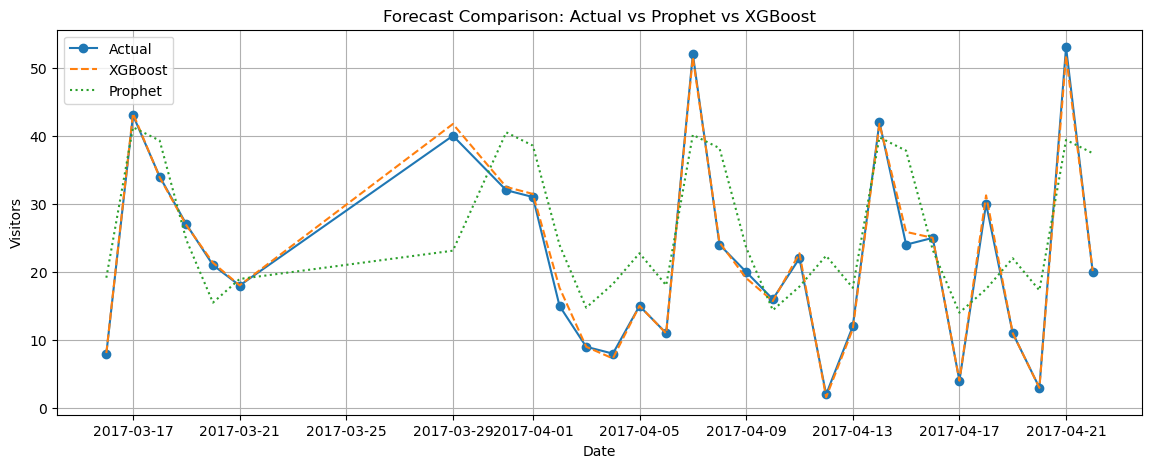

In [65]:
plt.figure(figsize=(14,5))
plt.plot(last_30['visit_date'], y_30, label='Actual', marker='o')
plt.plot(last_30['visit_date'], y_pred_xgb, label='XGBoost', linestyle='--')
plt.plot(prophet_pred.index, prophet_pred.values, label='Prophet', linestyle=':')
plt.title('Forecast Comparison: Actual vs Prophet vs XGBoost')
plt.ylabel('Visitors')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

Blue (Actual) shows true visitor counts. Orange (XGBoost) tracks very closely to the actual data. Green dotted (Prophet) captures the general trend but misses many spikes and dips.

Summary:

This analysis compares two forecasting models — Prophet and XGBoost — for predicting daily restaurant demand. Prophet effectively captures long-term trends and weekly seasonality, offering interpretable forecasts and confidence intervals. However, its forecasts are overly smooth and miss sharp demand fluctuations.

XGBoost, leveraging reservation data, lag features, and other engineered predictors, outperforms Prophet in short-term accuracy and responsiveness to dynamic patterns. Feature importance analysis confirms that reservation behavior and recent demand are the most influential inputs.

The combined EDA and modeling approach highlights the importance of calendar effects, customer reservation behavior, and store-specific variability. For operational forecasting, XGBoost is preferred; for strategic trend monitoring, Prophet provides valuable decomposition.